In [121]:
import numpy as np
import re
import string
import unicodedata
from collections import defaultdict, Counter
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Normalise text

In [122]:
# Remove all punctuation except !, ?, .
def clean_punctuation(text):
    text = re.sub(r'_', ' ', text) #_ is part of \w
    text = re.sub(r'(\d)[^\w\s.?!]+(\d)', r'\1 \2', text)
    text = re.sub(r'(\w)[^\w\s.?!]+(\w)', r'\1 \2', text)
    text = re.sub(r'[^\w\s.?!]', '', text)
    return text

# Remove !, ?, .
def remove_punctuation(text):
    text = re.sub(r'(\d)[?!\.]+(\d)', r'\1 \2', text)
    text = re.sub(r'(\w)[?!\.]+(\w)', r'\1 \2', text)
    text = re.sub(r'[?!\.]', '', text)
    return text

def remove_diacritics(text):
    normalized_text = unicodedata.normalize('NFKD', text)
    text = ''.join([c for c in normalized_text if not unicodedata.combining(c)])
    return text

def replace_digits_with_zeros(text):
    text = re.sub(r'\d', '0', text)
    text = re.sub(r'(\d)([a-zA-Z])', r'\1 \2', text)
    text = re.sub(r'([a-zA-Z])(\d)', r'\1 \2', text)
    return text

def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text)
    return text

def split_into_sentences(text):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<![A-Z]\.)(?<=\.|\?|!)\s', text)
    return sentences

def remove_non_ascii(text):
    return ''.join([ch for ch in text if ord(ch) < 128])

def process_text_file(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8') as outfile:
        for line in infile:
            line = clean_punctuation(line.strip())
            sentences = split_into_sentences(line)
            for sentence in sentences:
                if sentence:  # Avoid writing empty sentences
                    sentence = replace_digits_with_zeros(sentence)
                    sentence = remove_punctuation(sentence)
                    sentence = remove_diacritics(sentence)
                    sentence = replace_digits_with_zeros(sentence)
                    sentence = remove_extra_spaces(sentence)
                    sentence = sentence.lower()
                    outfile.write(sentence.strip() + '\n')

# Train models

In [123]:
vocab = ['[',']'] + list(' abcdefghijklmnopqrstuvwxyz0')
valid_vocab = [']'] + list(' abcdefghijklmnopqrstuvwxyz0')

In [124]:
def read_text(file_path):
    with open(file_path, 'r') as file:
        sentences = file.readlines()
    sentences = [re.sub(r'[^a-zA-Z0-9\s]', '', sentence) for sentence in sentences]
    sentences = [f"[[{sentence.strip()}]" for sentence in sentences if sentence.strip()]
    return sentences

def count_trigrams(sentences):
    trigram_counts = defaultdict(Counter)
    for sentence in sentences:
        chars = list(sentence)
        for i in range(len(chars) - 2):
            trigram_counts[(chars[i], chars[i+1])][chars[i+2]] += 1
    return trigram_counts

def estimate_probabilities(trigram_counts, valid_vocab, alpha=1):
    vocab_size = len(valid_vocab)
    trigram_probabilities = defaultdict(dict)
    
    for context, counter in trigram_counts.items():
        total_count = sum(counter.values()) + alpha*vocab_size  # C(w_t-2, w_t-1) + |V|
        for char in valid_vocab:
            trigram_probabilities[context][char] = (counter[char] + alpha) / total_count  # (C(w_t-2, w_t-1, w_t) + 1) / (C(w_t-2, w_t-1) + |V|)
    return trigram_probabilities

def calculate_perplexity(trigram_probabilities, sentences, valid_vocab, alpha=1):
    vocab_size = len(valid_vocab)
    log_prob_sum = 0
    total_trigrams = 0
    
    for sentence in sentences:
        chars = list(sentence)
        for i in range(len(chars) - 2):
            context = (chars[i], chars[i+1])
            next_char = chars[i+2]
            if context in trigram_probabilities and next_char in trigram_probabilities[context]:
                prob = trigram_probabilities[context][next_char]   
            else:
                prob = 1/(alpha*vocab_size)
            log_prob_sum += math.log(prob)
            total_trigrams += 1
    
    perplexity = math.exp(-log_prob_sum / total_trigrams)
    return perplexity

def generate_text(trigram_probabilities, max_length=100):
    text = ['[', '[']
    while len(text) < max_length:
        context = (text[-2], text[-1])
        if context not in trigram_probabilities:
            break
        char_probabilities = trigram_probabilities[context]
        chars, probs = zip(*char_probabilities.items())
        next_char = random.choices(chars, probs)[0]
        text.append(next_char)
        if next_char == ']':
            break
    return ''.join(text[2:-1])

def display_ngrams_with_history(trigram_probabilities, history):
    if history in trigram_probabilities:
        print(f"N-grams with history '{history}':")
        print(f"{'N-gram':<10}{'Probability':>15}")
        print("-" * 25)
        for char, prob in sorted(trigram_probabilities[history].items(), key=lambda item: -item[1]):
            print(f"{history[0]}{history[1]}{char:<10} {prob:.6f}")
    else:
        print(f"No N-grams found with history '{history}'.")

### Explore smoothing techniques

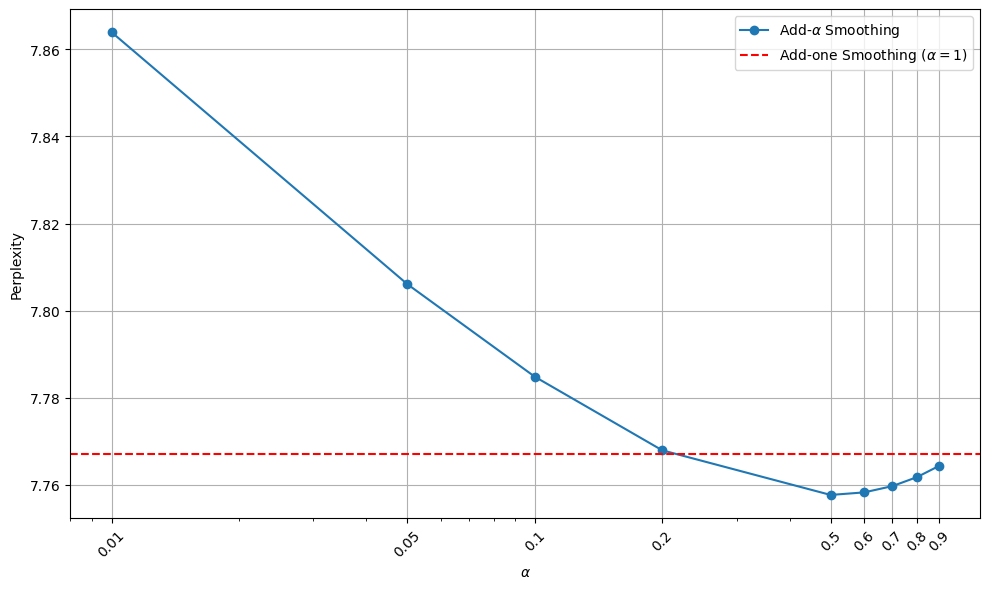

In [125]:
input_file = 'data/train.en.txt'
output_file = 'norm/train.en.norm.txt'
process_text_file(input_file, output_file)

sentences_en = read_text('norm/train.en.norm.txt')
trigram_counts_en = count_trigrams(sentences_en)

alpha_values = [0.01, 0.05, 0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9]
perplexities = []

for alpha in alpha_values:
    trigram_probabilities = estimate_probabilities(trigram_counts_en, valid_vocab, alpha=alpha)
    perplexity = calculate_perplexity(trigram_probabilities, read_text('data/val.en.txt'), valid_vocab, alpha=alpha)
    perplexities.append(perplexity)

add_one_alpha = 1.0
add_one_trigram_probabilities = estimate_probabilities(trigram_counts_en, valid_vocab, alpha=add_one_alpha)
add_one_perplexity = calculate_perplexity(add_one_trigram_probabilities, read_text('data/val.en.txt'), valid_vocab, alpha=add_one_alpha)

plt.figure(figsize=(10, 6))
plt.plot(alpha_values, perplexities, marker='o', label=r'Add-$\alpha$ Smoothing')
plt.axhline(y=add_one_perplexity, color='r', linestyle='--', label=r'Add-one Smoothing $(\alpha=1)$')
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('Perplexity')
plt.grid(True)

plt.xticks(alpha_values, labels=[str(alpha) for alpha in alpha_values], rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

## Model English

### Generate sentence

In [126]:
input_file = 'data/train.en.txt'
output_file = 'norm/train.en.norm.txt'

process_text_file(input_file, output_file)

sentences_en = read_text('norm/train.en.norm.txt')
trigram_counts_en = count_trigrams(sentences_en)
trigram_probabilities_en = estimate_probabilities(trigram_counts_en, valid_vocab, alpha=0.5)
generated_text_en = generate_text(trigram_probabilities_en, max_length=100)
print(generated_text_en)

ing then 000 secal fic wern anar pajohnommer thein a bon buto dand ocuppre reen sheirearthe uster


### Calculate preplexity

In [127]:
perplexity_en = calculate_perplexity(trigram_probabilities_en, read_text('data/val.en.txt'), valid_vocab, alpha=0.5)
print(perplexity_en)

7.757687079506814


### Display n-grams

In [128]:
display_ngrams_with_history(trigram_probabilities_en, ('t', 'h'))

N-grams with history '('t', 'h')':
N-gram        Probability
-------------------------
the          0.680129
th           0.101523
tha          0.083028
thi          0.044692
tho          0.037966
thr          0.033864
thn          0.004607
ths          0.003262
th]          0.002993
thu          0.002388
thy          0.001984
thw          0.000706
thd          0.000639
thl          0.000572
thm          0.000437
thc          0.000303
tht          0.000235
thp          0.000168
thb          0.000101
thf          0.000101
thg          0.000034
thh          0.000034
thj          0.000034
thk          0.000034
thq          0.000034
thv          0.000034
thx          0.000034
thz          0.000034
th0          0.000034


## Model Afrikaans

### Generate sentence

In [129]:
input_file = 'data/train.af.txt'
output_file = 'norm/train.af.norm.txt'

process_text_file(input_file, output_file)

sentences_af = read_text('norm/train.af.norm.txt')
trigram_counts_af = count_trigrams(sentences_af)
trigram_probabilities_af = estimate_probabilities(trigram_counts_af, valid_vocab, alpha=0.5)
generated_text_af = generate_text(trigram_probabilities_af, max_length=100)
print(generated_text_af)

dusse gevano warike ger ven vierklin han neer hy die het hy  uitstiwike om dinge


### Calculate preplexity

In [130]:
perplexity_af = calculate_perplexity(trigram_probabilities_af, read_text('data/val.af.txt'), valid_vocab, alpha=0.5)
print(perplexity_af)

8.037970200245763


### Model Dutch

### Generate sentence

In [131]:
input_file = 'data/train.nl.txt'
output_file = 'norm/train.nl.norm.txt'

process_text_file(input_file, output_file)

sentences_nl = read_text('norm/train.nl.norm.txt')
trigram_counts_nl = count_trigrams(sentences_nl)
trigram_probabilities_nl = estimate_probabilities(trigram_counts_nl, valid_vocab, alpha=0.5)
generated_text_nl = generate_text(trigram_probabilities_nl, max_length=100)
print(generated_text_nl)

de krieschodivin daarchrit dero wor lijn evollederden ben vsumptis het ligt planken zonca dorregi


### Calculate preplexity

In [132]:
perplexity_nl = calculate_perplexity(trigram_probabilities_nl, read_text('data/val.nl.txt'), valid_vocab, alpha=0.5)
print(perplexity_nl)

7.815705496373253


### Model Xhosa

### Generate sentence

In [133]:
input_file = 'data/train.xh.txt'
output_file = 'norm/train.xh.norm.txt'

process_text_file(input_file, output_file)

sentences_xh = read_text('norm/train.xh.norm.txt')
trigram_counts_xh = count_trigrams(sentences_xh)
trigram_probabilities_xh = estimate_probabilities(trigram_counts_xh, valid_vocab, alpha=0.5)
generated_text_xh = generate_text(trigram_probabilities_xh, max_length=100)
print(generated_text_xh)

ezixhosanye ke zair ngqingache itibhi hacalo ezinindowe layo ixes umadwaziyeye ebu iziyo


### Calculate preplexity

In [134]:
perplexity_xh = calculate_perplexity(trigram_probabilities_xh, read_text('data/val.xh.txt'), valid_vocab, alpha=0.5)
print(perplexity_xh)

8.292132115185854


### Model Zulu

### Generate sentence

In [135]:
input_file = 'data/train.zu.txt'
output_file = 'norm/train.zu.norm.txt'

process_text_file(input_file, output_file)

sentences_zu = read_text('norm/train.zu.norm.txt')
trigram_counts_zu = count_trigrams(sentences_zu)
trigram_probabilities_zu = estimate_probabilities(trigram_counts_zu, valid_vocab, alpha=0.5)
generated_text_zu = generate_text(trigram_probabilities_zu, max_length=100)
print(generated_text_zu)

uhlude ifungizwebe afriyanye ukenganjenzileke p


### Calculate preplexity

In [136]:
perplexity_zu = calculate_perplexity(trigram_probabilities_zu, read_text('data/val.zu.txt'), valid_vocab, alpha=0.5)
print(perplexity_zu)

8.40422570635052


## Preplexity confusion matrix

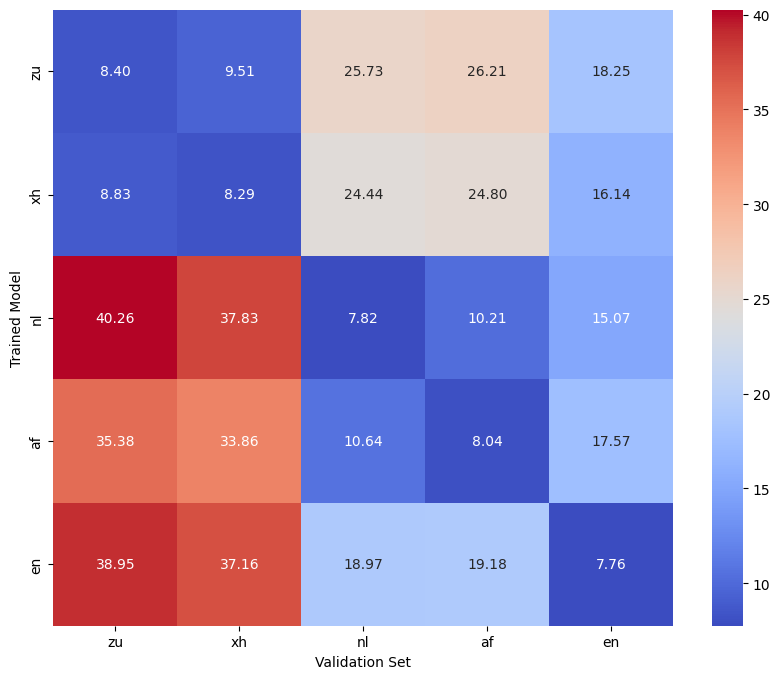

In [137]:
trigram_probabilities = {
    'zu': trigram_probabilities_zu,
    'xh': trigram_probabilities_xh,
    'nl': trigram_probabilities_nl,
    'af': trigram_probabilities_af,
    'en': trigram_probabilities_en,
}

languages = ['zu', 'xh', 'nl', 'af', 'en']
validation_files = {
    'zu': 'data/val.zu.txt',
    'xh': 'data/val.xh.txt',
    'nl': 'data/val.nl.txt',
    'af': 'data/val.af.txt',
    'en': 'data/val.en.txt',
}

perplexity_matrix = []
for model_lang in languages:
    perplexities_for_model = []
    for val_lang in languages:
        validation_sentences = read_text(validation_files[val_lang])
        perplexity = calculate_perplexity(trigram_probabilities[model_lang], validation_sentences, valid_vocab, alpha=0.5)
        perplexities_for_model.append(perplexity)
    perplexity_matrix.append(perplexities_for_model)

plt.figure(figsize=(10, 8))
sns.heatmap(perplexity_matrix, xticklabels=languages, yticklabels=languages, annot=True, fmt=".2f", cmap="coolwarm")
plt.xlabel('Validation Set')
plt.ylabel('Trained Model')
plt.show()

## Language identification

In [138]:
def read_test_dataset(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    sentences = []
    languages = []
    for line in lines:
        parts = line.strip().split(' ', 1)
        if len(parts) == 2:
            lang, sentence = parts
            sentences.append(sentence)
            languages.append(lang)
    return languages, sentences

In [139]:
def identify_language(trigram_probabilities, sentence):
    min_perplexity = float('inf')
    best_language = None
    for lang, model in trigram_probabilities.items():
        perplexity = calculate_perplexity(model, [f"[[{sentence}]"], valid_vocab, alpha=0.5)
        if perplexity < min_perplexity:
            min_perplexity = perplexity
            best_language = lang
    return best_language

In [140]:
def calculate_accuracy(true_languages, predicted_languages):
    correct = 0
    for true_lang, pred_lang in zip(true_languages, predicted_languages):
        if true_lang == pred_lang:
            correct += 1
    return correct / len(true_languages)

In [141]:
trigram_probabilities = {
    'zu': trigram_probabilities_zu,
    'xh': trigram_probabilities_xh,
    'nl': trigram_probabilities_nl,
    'af': trigram_probabilities_af,
    'en': trigram_probabilities_en,
}

test_file_path = 'data/test.lid.txt'

true_languages, test_sentences = read_test_dataset(test_file_path)

predicted_languages = []
for sentence in test_sentences:
    predicted_lang = identify_language(trigram_probabilities, sentence)
    predicted_languages.append(predicted_lang)

accuracy = calculate_accuracy(true_languages, predicted_languages)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 91.29%


In [142]:
print("First 20 Incorrect Predictions:")
incorrect_predictions = 0
for true_lang, pred_lang, sentence in zip(true_languages, predicted_languages, test_sentences):
    if true_lang != pred_lang:
        print(f"True: {true_lang}, Predicted: {pred_lang}, Sentence: {sentence}")
        incorrect_predictions += 1
        if incorrect_predictions >= 20:
            break

First 20 Incorrect Predictions:
True: zu, Predicted: xh, Sentence: umbhalo
True: nl, Predicted: zu, Sentence: zuidafrika
True: xh, Predicted: zu, Sentence: utonyane khonyane lo uzalwa nguntsane kamonaheng
True: zu, Predicted: xh, Sentence: brough amamormon labo ababebhapathizwa 000 000 ukuqothulwa kwesizwe izisulu kwakhe abangu eshukunyiswa uthando nesihe futhi abazange baqonde isenzo sabo kungase kubacasule amajuda
True: zu, Predicted: xh, Sentence: iquran ayikaze ikhulume ngoyise kajona kodwa isiko lamasulumane lifundisa ukuthi ujona wayevela esizweni sakwabenjamini nokuthi ubaba wakhe kwakungu amittai
True: nl, Predicted: af, Sentence: bevolking
True: zu, Predicted: xh, Sentence: ukubaluleka kanye neziqu eziyisisekelo
True: nl, Predicted: zu, Sentence: brazilie
True: zu, Predicted: xh, Sentence: ukulungiselela
True: zu, Predicted: xh, Sentence: kodwake ukusebenzela imishini akudingeki ukuze uqhubeke ubulungu besonto
True: zu, Predicted: af, Sentence: amaallergener
True: zu, Predicte

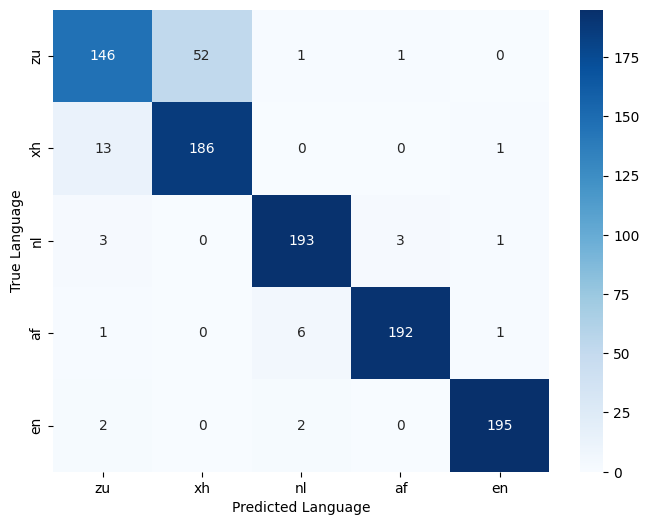

In [143]:
languages = list(trigram_probabilities.keys())

conf_matrix = np.zeros((len(languages), len(languages)), dtype=int)

lang_to_index = {lang: i for i, lang in enumerate(languages)}

for true_lang, pred_lang in zip(true_languages, predicted_languages):
    if true_lang in lang_to_index and pred_lang in lang_to_index:
        true_index = lang_to_index[true_lang]
        pred_index = lang_to_index[pred_lang]
        conf_matrix[true_index, pred_index] += 1

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=languages, yticklabels=languages)
plt.xlabel('Predicted Language')
plt.ylabel('True Language')
plt.show()

## Byte-pair encoding for language similarity

In [144]:
def read_text(file_path):
    with open(file_path, 'r') as file:
        sentences = file.readlines()
    sentences = [re.sub(r'[^a-zA-Z0-9\s]', '', sentence) for sentence in sentences]
    return sentences

def tokenize(sentences):
    tokenized_sentences = []
    for sentence in sentences:
        tokenized_sentence = list(sentence)
        tokenized_sentences.append(tokenized_sentence)
    return tokenized_sentences

def get_pair_counts(tokenized_sentences):
    pair_counts = Counter()
    for sentence in tokenized_sentences:
        for i in range(len(sentence) - 1):
            pair = (sentence[i], sentence[i+1])
            pair_counts[pair] += 1
    return pair_counts

def merge_pair(pair, tokenized_sentences):
    merged_sentences = []
    bigram = ''.join(pair)
    for sentence in tokenized_sentences:
        new_sentence = []
        i = 0
        while i < len(sentence):
            if i < len(sentence) - 1 and sentence[i] == pair[0] and sentence[i+1] == pair[1]:
                new_sentence.append(bigram)
                i += 2
            else:
                new_sentence.append(sentence[i])
                i += 1
        merged_sentences.append(new_sentence)
    return merged_sentences

def apply_bpe(sentences, num_iterations):
    tokenized_sentences = tokenize(sentences)
    merges = []
    for _ in range(num_iterations):
        pair_counts = get_pair_counts(tokenized_sentences)
        if not pair_counts:
            break
        most_frequent_pair = pair_counts.most_common(1)[0][0]
        tokenized_sentences = merge_pair(most_frequent_pair, tokenized_sentences)
        merges.append(most_frequent_pair)
    return merges

First ten merges for zu: [('a', ' '), ('i', ' '), ('n', 'g'), ('e', ' '), ('a', 'n'), ('o', ' '), ('k', 'u'), ('t', 'h'), ('e', 'l'), ('z', 'i')]
First ten merges for xh: [('a', ' '), ('e', ' '), ('i', ' '), ('o', ' '), ('a', 'n'), ('k', 'u'), ('n', 'g'), ('e', 'l'), ('i', 'n'), ('e', 'n')]
First ten merges for nl: [('n', ' '), ('e', ' '), ('e', 'n '), ('e', 'r'), ('t', ' '), ('d', 'e '), ('e', 'n'), ('a', 'a'), ('s', ' '), ('e', 'l')]
First ten merges for af: [('e', ' '), ('n', ' '), ('e', 'r'), ('d', 'i'), ('di', 'e '), ('s', ' '), ('t', ' '), ('a', 'n'), ('0', '0'), ('e', 'l')]
First ten merges for en: [('e', ' '), ('s', ' '), ('t', 'h'), ('d', ' '), ('i', 'n'), ('a', 'n'), ('e', 'r'), ('o', 'n'), ('th', 'e '), ('t', ' ')]
Overlap between zu and xh: 77 subwords
Overlap between zu and nl: 21 subwords
Overlap between zu and af: 26 subwords
Overlap between zu and en: 32 subwords
Overlap between xh and zu: 77 subwords
Overlap between xh and nl: 18 subwords
Overlap between xh and af: 24 

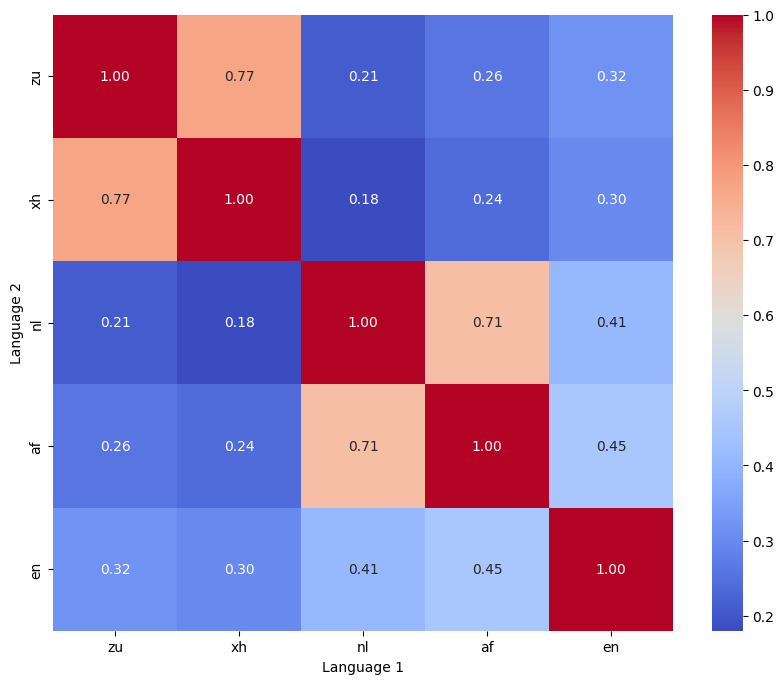

In [145]:
training_files = {
    'zu': 'norm/train.zu.norm.txt',
    'xh': 'norm/train.xh.norm.txt',
    'nl': 'norm/train.nl.norm.txt',
    'af': 'norm/train.af.norm.txt',
    'en': 'norm/train.en.norm.txt'
}

all_merges = {}
for lang, file_path in training_files.items():
    sentences = read_text(file_path)
    merges = apply_bpe(sentences, 100)
    all_merges[lang] = merges
    print(f"First ten merges for {lang}: {merges[:10]}")

def get_subword_vocabulary(merges):
    subword_vocab = set()
    for merge in merges:
        subword_vocab.add(''.join(merge))
    return subword_vocab

languages = list(training_files.keys())
overlap_matrix = []

for i in range(len(languages)):
    row = []
    for j in range(len(languages)):
        if i == j:
            row.append(1.0)
        else:
            lang1 = languages[i]
            lang2 = languages[j]
            vocab1 = get_subword_vocabulary(all_merges[lang1])
            vocab2 = get_subword_vocabulary(all_merges[lang2])
            overlap = vocab1 & vocab2
            print(f"Overlap between {lang1} and {lang2}: {len(overlap)} subwords")

            overlap_score = len(overlap) / min(len(vocab1), len(vocab2)) 
            row.append(overlap_score)
    overlap_matrix.append(row)

plt.figure(figsize=(10, 8))
sns.heatmap(overlap_matrix, xticklabels=languages, yticklabels=languages, annot=True, fmt=".2f", cmap="coolwarm")
plt.xlabel('Language 1')
plt.ylabel('Language 2')
plt.show()